In [1]:
from pathlib import Path
import csv
import pickle

## Load the dataset

In [2]:
data_dir = Path("../data")
hurtlex_file = "revised_hurtlex.tsv"

lexicon_list = []
with open(data_dir / hurtlex_file) as infile:
    reader = csv.DictReader(infile, delimiter='\t')
    for row in reader:
        lexicon_list.append(row)

In [3]:
lexicon_list[0].keys()

dict_keys(['pos', 'category', 'lemma', 'offensiveness_score'])

In [4]:
lexicon_list[10]['category'].split(';')

['qas', 'ddf', '']

In [5]:
def get_score(item):
    try:
        score = float(item['offensiveness_score'])
    except TypeError:
        score = 0
    return score

In [6]:
def get_categories(item):
    category_list = item['category'].split(';')
    categories = [cat.strip() for cat in category_list if cat]
    return categories

In [7]:
set([cat
     for item in lexicon_list
     for cat in get_categories(item)])

{'an',
 'asf',
 'asm',
 'cds',
 'ddf',
 'ddp',
 'dfc',
 'dm',
 'dmc',
 'is',
 'mal',
 'mi',
 'min',
 'om',
 'op',
 'or',
 'pa',
 'pr',
 'ps',
 'qas',
 'rci',
 're',
 'svp'}

In [8]:
lexicon_dict = {
    item['lemma'] : (get_score(item), get_categories(item))
    for item in lexicon_list
}

In [9]:
lexicon_dict.get("zavorra")

(1.9338529209592425, ['qas'])

## Annotate Documents

### Global offensiveness score

We simply attribute to each document an offensiveness score which is the sum of the scores of all lemmas in the document.

We use the text already lemmatized with the Stanza pipeline.

In [10]:
results_dir = Path("../results")
pickle_file = "stanza_proc_train.pkl"

with open(results_dir / pickle_file, 'rb') as infile:
    train_set = pickle.load(infile)

/home/fab/.anaconda3/envs/txa_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
doc = train_set[100]['proc_text']

In [12]:
def get_offensiveness_score(document):
    score = 0
    for word in document['proc_text'].iter_words():
        score += lexicon_dict.get(word.lemma, (0, None))[0]
    return score, score / document['proc_text'].num_tokens

In [13]:
scores = []

for document in train_set:
    scores.append(get_offensiveness_score(document))

In [14]:
import pandas as pd

scores_df = pd.DataFrame(scores, index=[doc['id'] for doc in train_set], columns=['offensiveness_score', 'offensiveness_score_norm'])
scores_df.sort_values('offensiveness_score_norm', ascending=False).head(20)

,offensiveness_score,offensiveness_score_norm
7595,20.456301,1.859664
8366,13.909649,1.390965
5152,15.309219,1.275768
2412,5.000000,1.250000
8389,16.007915,1.231378
4191,4.731971,1.182993
1976,3.293039,1.097680
7663,10.451695,1.045170
6829,11.370017,1.033638
2280,13.311769,1.023982


In [15]:
scores_df.to_csv(results_dir / 'offensiveness_train.csv')

### Offensiveness by category

Each offensive term in the hurtlex lexicon is related to one or more categories.
We want to compute the offensiveness of each document with reference to each category.

In [16]:
def get_offensiveness_score_by_cat(document):
    scores = dict()
    for word in document['proc_text'].iter_words():
        score, categories = lexicon_dict.get(word.lemma, (0, None))
        if score:
            try:
                for cat in categories:
                    scores[cat] = scores.get(cat, 0) + score
            except Exception:
                print(categories)
                break
    return scores

In [17]:
scores = []
for document in train_set:
    scores.append(get_offensiveness_score_by_cat(document))

In [18]:
scores_by_cat_df = pd.DataFrame(scores, index=[doc['id'] for doc in train_set]).fillna(0)
scores_by_cat_df.columns

Index(['rci', 'ps', 'ddp', 'qas', 'dmc', 'cds', 're', 'svp', 'is', 'an', 'min',
       'op', 'dfc', 'pr', 'asf', 'mi', 'asm', 'ddf', 'pa', 'mal', 'or', 'om'],
      dtype='object')

In [19]:
scores_by_cat_df.to_csv(results_dir / 'offensiveness_by_cat_train.csv')

## Offensiveness of newspaper headlines

In [20]:
pickle_file = "stanza_proc_train_headlines.pkl"

with open(results_dir / pickle_file, 'rb') as infile:
    headlines = pickle.load(infile)

In [21]:
scores = []
for document in headlines:
    scores.append(get_offensiveness_score(document))

scores_headlines_df = pd.DataFrame(scores, index=[doc['id'] for doc in headlines], columns=['offensiveness_score', 'offensiveness_score_norm'])
scores_headlines_df.sort_values('offensiveness_score_norm', ascending=False).head(10)

,offensiveness_score,offensiveness_score_norm
H57,11.036522,1.226280
H541,8.293039,0.637926
H407,11.383455,0.599129
H748,8.293039,0.592360
H409,6.351990,0.577454
H314,5.597935,0.559793
H583,3.293039,0.548840
H584,10.224168,0.538114
H187,10.726499,0.536325
H523,5.297178,0.529718


## Normalize or not?

In [23]:
scores_headlines_df['type'] = 'headline'
scores_df['type'] = 'tweet'

scores_df = pd.concat([scores_df, scores_headlines_df])

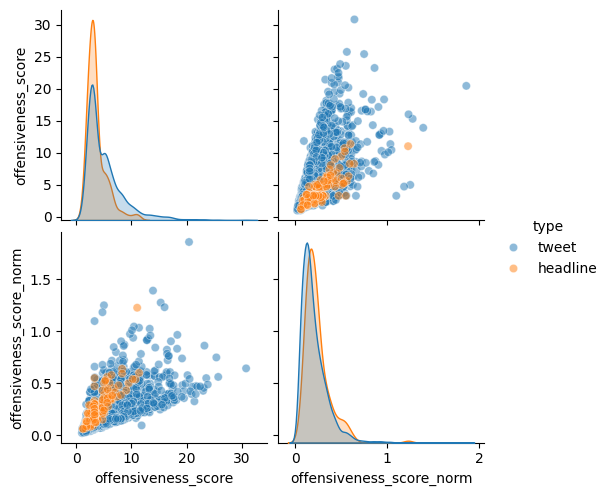

In [30]:
import seaborn as sns

sns.pairplot(scores_df[scores_df['offensiveness_score'] > 0],
             hue='type',
             plot_kws={'alpha': .5},
             diag_kws={'common_norm': False})

In [36]:
scores_df.groupby('type').corr()

offensiveness_score  \
type                                                     
headline offensiveness_score                  1.000000   
         offensiveness_score_norm             0.949848   
tweet    offensiveness_score                  1.000000   
         offensiveness_score_norm             0.816063   

                                   offensiveness_score_norm  
type                                                         
headline offensiveness_score                       0.949848  
         offensiveness_score_norm                  1.000000  
tweet    offensiveness_score                       0.816063  
         offensiveness_score_norm                  1.000000

In [35]:
scores_df[scores_df['offensiveness_score'] > 0].groupby('type').corr()

offensiveness_score  \
type                                                     
headline offensiveness_score                  1.000000   
         offensiveness_score_norm             0.837943   
tweet    offensiveness_score                  1.000000   
         offensiveness_score_norm             0.629070   

                                   offensiveness_score_norm  
type                                                         
headline offensiveness_score                       0.837943  
         offensiveness_score_norm                  1.000000  
tweet    offensiveness_score                       0.629070  
         offensiveness_score_norm                  1.000000

We noticed that raw offensiveness scores were systematically lower for headlines, which could be an artifact of the reduced length of these document (but not necessarily: it may be true that headlines are generally less offensive than tweets).

The normalization of the score by number of token does indeed make the distribution of this variable in the two domains nearly indistinguishable (only documents with an offensiveness score stricly major than 0 are considered). The normalized and non normalized scores are highly correlated (more so for the headlines than the tweets, since headlines are more uniform in terms of length)&mdash;even when all documents with no offensive words are removed. It probably would be wise to consider which score proves more effective during model selection (it can also be both).